In [ ]:
#Idea
#-Learn the ODE pointwise for each time point
#-each net predicting next 3 steps, then they are coupled!!

In [1]:
import sys
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils import *
from torchsummary import summary
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)
import os      
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"   

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
#Data Loader
I_train, I_test, _, _, Tep_train, Tep_test, q_us_train, q_us_test, dqdt_us_train, dqdt_us_test = load_data()

I_mu = I_train.mean(axis=0)
I_sigma = I_train.std(axis=0)
I_train_sc = (I_train - I_mu)/I_sigma

I_test_sc = (I_test - I_mu)/I_sigma

I_train = I_train
dqdt_us_train = dqdt_us_train

#--- dqdt scaled ---
dqdt_mu = torch.mean(dqdt_us_train)
dqdt_sigma = torch.std(dqdt_us_train)

dqdt_sc_train = (dqdt_us_train - dqdt_mu) / dqdt_sigma
dqdt_sc_test = (dqdt_us_test - dqdt_mu) / dqdt_sigma

#--- q scaled ---
q_mu = q_us_train.mean()
q_sigma = q_us_train.std()

q_sc_train = (q_us_train - q_mu) / q_sigma
q_sc_test = (q_us_test - q_mu) / q_sigma

In [3]:
class Big_Sep_Net(nn.Module):

    def __init__(self):
        super(Big_Sep_Net, self).__init__()
        
        self.which_net = 0
        
        self.w1 = torch.nn.Parameter(data=torch.Tensor(50, 30, 11), requires_grad=True)
        self.w1.data.uniform_(-1, 1)
        
        self.b1 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b1.data.uniform_(-1, 1)      
        
        self.w2 = torch.nn.Parameter(data=torch.Tensor(50, 11, 11), requires_grad=True)
        self.w2.data.uniform_(-1, 1)
        
        self.b2 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b2.data.uniform_(-1, 1)
        
        self.w3 = torch.nn.Parameter(data=torch.Tensor(50, 11, 11), requires_grad=True)
        self.w3.data.uniform_(-1, 1)
        
        self.b3 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b3.data.uniform_(-1, 1)
        
        self.w4 = torch.nn.Parameter(data=torch.Tensor(50, 11, 10), requires_grad=True)
        self.w4.data.uniform_(-1, 1)
        
        self.b4 = torch.nn.Parameter(data=torch.Tensor(50, 10), requires_grad=True)
        self.b4.data.uniform_(-1, 1)

        self.w5 = torch.nn.Parameter(data=torch.Tensor(50, 10, 1), requires_grad=True)
        self.w5.data.uniform_(-1, 1)
        
        self.b5 = torch.nn.Parameter(data=torch.Tensor(50, 1), requires_grad=True)
        self.b5.data.uniform_(-1, 1)
        
    def forward(self, Is):
        
        x = Is[:,None]
        
        
        x = torch.einsum('ijk,jkl->ijl', x, self.w1) + self.b1
        x = nn.ReLU()(x)

        
        x = x + nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w2) + self.b2 )
        
        x = x + nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w3) + self.b3 )
        
        x = nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w4) + self.b4 )
        
        dqdts = torch.einsum('ijk,jkl->ijl', x, self.w5) + self.b5

        return dqdts.squeeze()

In [4]:
class FinishLSTM(torch.nn.Module):
    def __init__(self):
        super(FinishLSTM, self).__init__()
        self.d1 = torch.nn.Linear(50, 100)
        self.d2 = torch.nn.Linear(100, 150)
        self.lstm1 = torch.nn.LSTM(3, 1, num_layers=1, batch_first=True)
        
        self.lstm2 = torch.nn.LSTM(2, 2, num_layers=1, batch_first=True)
        self.d3 = torch.nn.Linear(50, 50)
        
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)
        
        self.q_net = torch.load('models/big_sep_net_single_positions1.pt')
        self.dqdt_net = torch.load('models/big_sep_net_single.pt')
        
    def forward(self, x):
#         with torch.no_grad():
        dqdt = self.dqdt_net(x)
        q = self.q_net(x)
        
        dqdt = self.d1(dqdt)
        dqdt = self.tanh(dqdt)
        
        q = self.d1(q)
        q = self.tanh(q)
        
        dqdt = self.d2(dqdt)
        dqdt = self.tanh(dqdt)
        
        q = self.d2(q)
        q = self.tanh(q)

        dqdt = dqdt.reshape(-1, 50, 3)
        q = q.reshape(-1, 50, 3)
        
        dqdt, _ = self.lstm1(dqdt)
        
        q, _ = self.lstm1(q)
        
        x = torch.cat((dqdt, q), axis=-1)
        
        x = self.tanh(x)

        x, _ = self.lstm2(x, (torch.zeros(1, x.size(0), 2).to(device), torch.zeros(1, x.size(0), 2).to(device)))
        
        x = self.tanh(x)
        
        dqdt = x[..., 0]
        q = x[..., 1]

        dqdt = self.d3(dqdt)
        q = self.d3(q)
        
        return dqdt, q

In [5]:
net = FinishLSTM().to(device)
summary(net);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            5,100
├─Linear: 1-2                            15,150
├─LSTM: 1-3                              24
├─LSTM: 1-4                              48
├─Linear: 1-5                            2,550
├─Tanh: 1-6                              --
├─ReLU: 1-7                              --
├─Dropout: 1-8                           --
├─Big_Sep_Net: 1-9                       36,800
├─Big_Sep_Net: 1-10                      36,800
Total params: 96,472
Trainable params: 96,472
Non-trainable params: 0


In [6]:
def trainer(batch_size = 3200, epochs = 50, lr = 0.001):
    net.train()
    
    loss_fn = torch.nn.MSELoss()
    for epoch in range(1, epochs + 1):
        trainloader = torch.utils.data.DataLoader(
                                            torch.arange(len(I_train)), 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            drop_last=False)

        running_loss = 0
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        for i, batch_indxs in enumerate(trainloader, 0):

            dqdts_sc_target_batch = dqdt_sc_train[batch_indxs] 
            q_sc_target_batch = q_sc_train[batch_indxs]

            Is = I_train_sc[batch_indxs]
            
            dqdt_sc_pred, q_sc_pred = net(Is)
            
            q_loss = loss_fn(q_sc_pred, q_sc_target_batch)
                        
            dqdt_loss = loss_fn(dqdt_sc_pred, dqdts_sc_target_batch)
            
            loss = q_loss + dqdt_loss

            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            percent = (i + 1) / len(trainloader) * 100
            print(f'Epoch {epoch} \t{loss.item():.8f}\t{percent:.0f}%', end='\r')
            #sys.stdout.flush()

        print('\nAverage loss =', running_loss / len(trainloader))
    

In [12]:
batch_size = 32
epochs = 30
lr = 0.0001

trainer(batch_size=batch_size, epochs=epochs, lr=lr)

Epoch 1 	0.00882645	100%
Average loss = 0.008380109346434439
Epoch 2 	0.00802728	100%
Average loss = 0.0080758599291134
Epoch 3 	0.00443358	100%
Average loss = 0.007980631674265685
Epoch 4 	0.00855366	100%
Average loss = 0.00790928380811272
Epoch 5 	0.00564432	100%
Average loss = 0.007859468995494785
Epoch 6 	0.00885550	100%
Average loss = 0.007827428006358687
Epoch 7 	0.00584778	100%
Average loss = 0.007789650394787877
Epoch 8 	0.00919928	100%
Average loss = 0.0077486207552545485
Epoch 9 	0.00759446	100%
Average loss = 0.007719578019207763
Epoch 10 	0.00573188	100%
Average loss = 0.007692456227655729
Epoch 11 	0.00609235	100%
Average loss = 0.007661221474119573
Epoch 12 	0.00654055	100%
Average loss = 0.007643318463299376
Epoch 13 	0.00512059	100%
Average loss = 0.007624191309343383
Epoch 14 	0.00941140	100%
Average loss = 0.00760503201423019
Epoch 15 	0.00684424	100%
Average loss = 0.0075872082193480786
Epoch 16 	0.01120390	100%
Average loss = 0.0075656426368606745
Epoch 17 	0.005499

In [18]:
dqdt_out, q_out = net(I_test_sc)

print('MSE Loss on test =', 
      torch.nn.MSELoss()(dqdt_out, dqdt_sc_test).item() + torch.nn.MSELoss()(q_out, q_sc_test).item())

MSE Loss on test = 0.010995123884640634


In [19]:
torch.save(net, 'models/dqdt_q_lstm.pt')

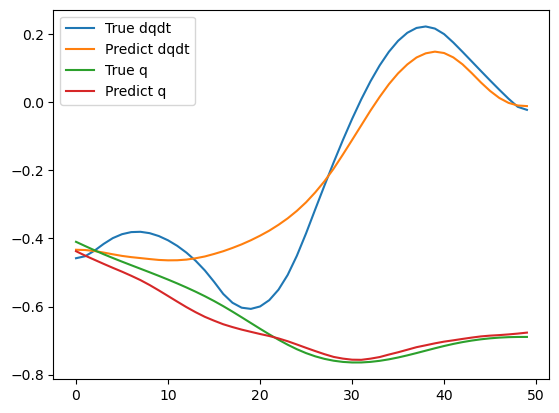

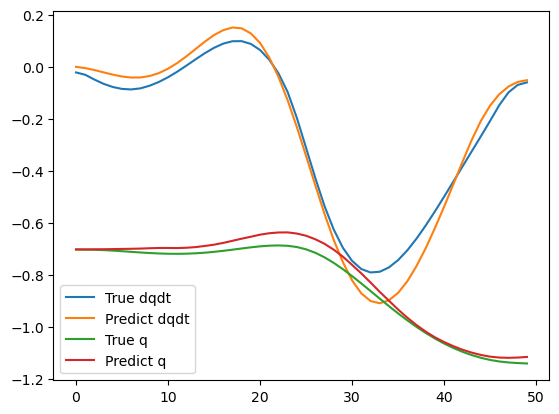

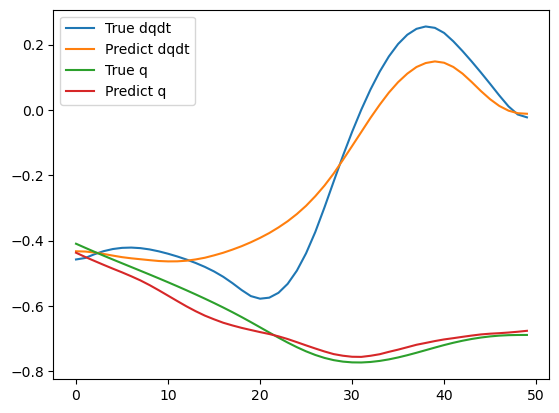

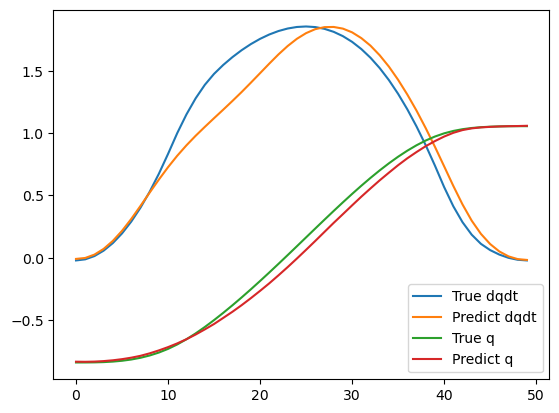

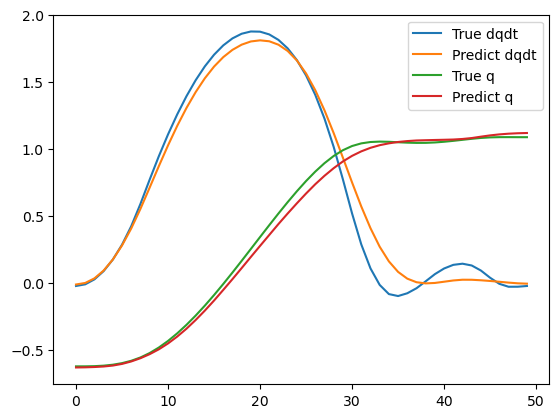

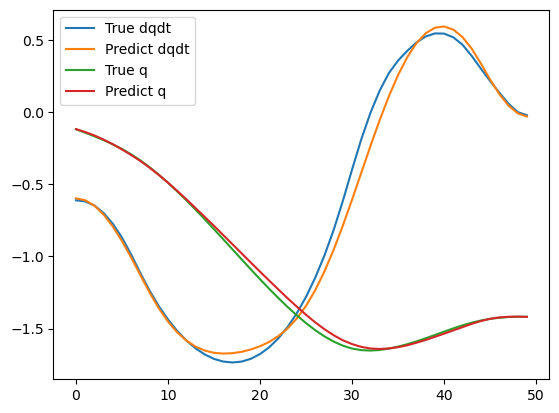

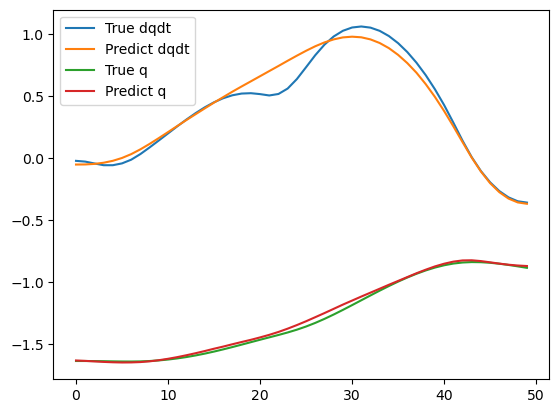

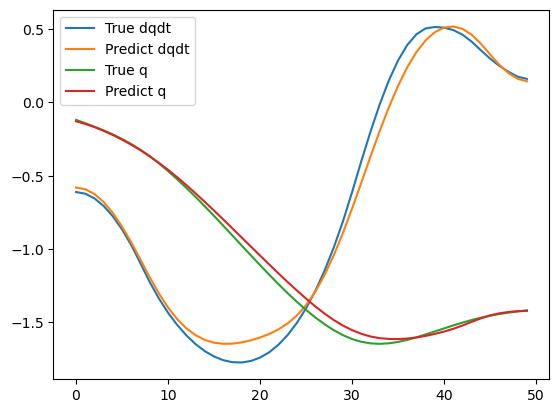

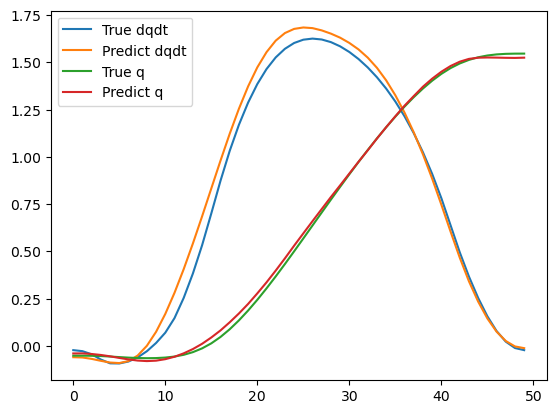

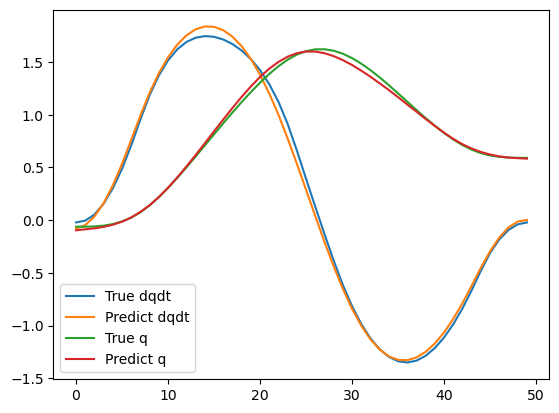

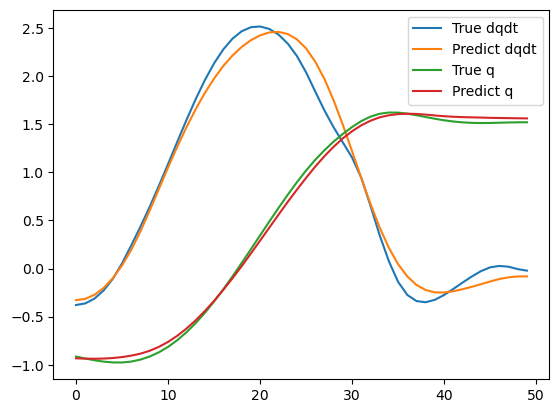

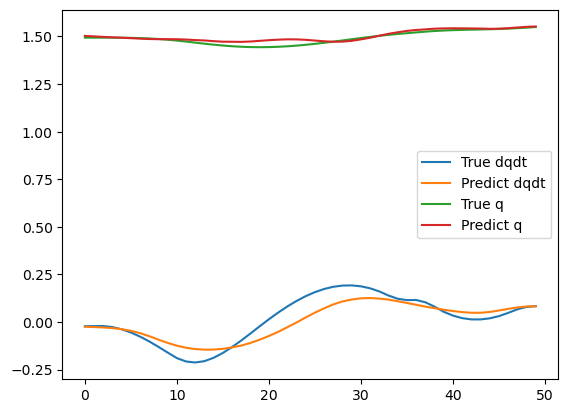

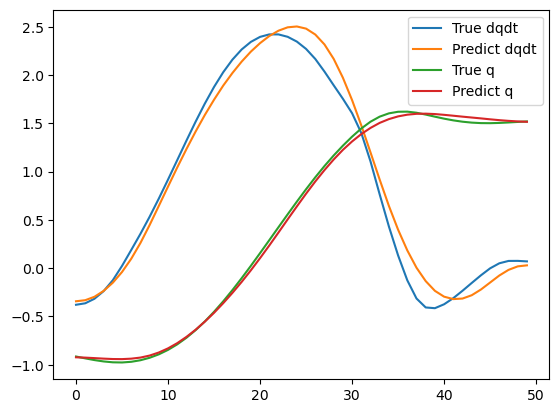

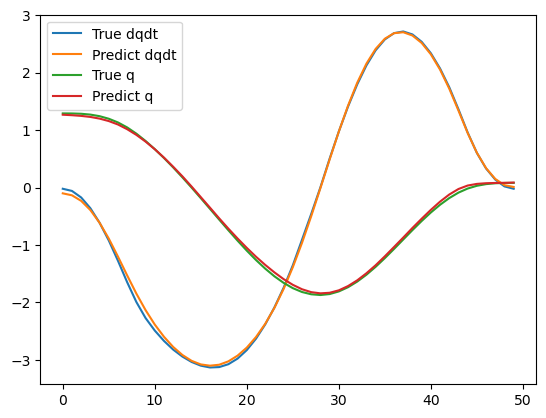

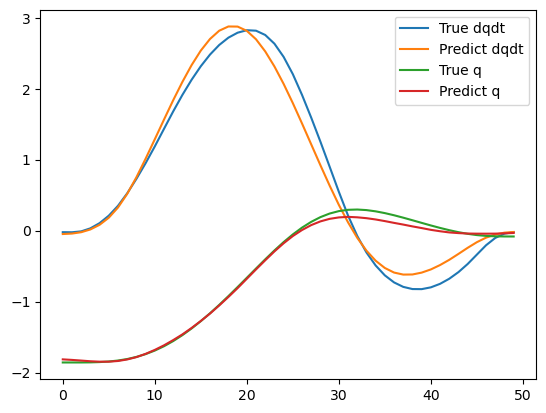

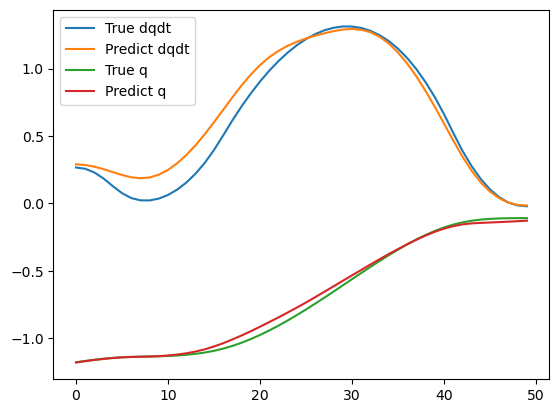

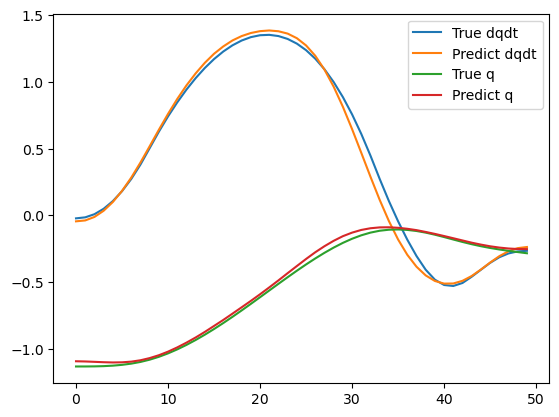

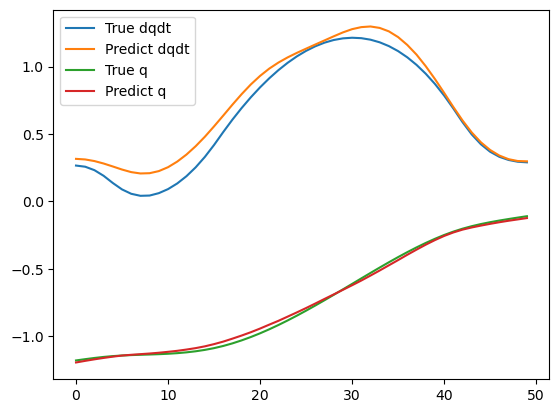

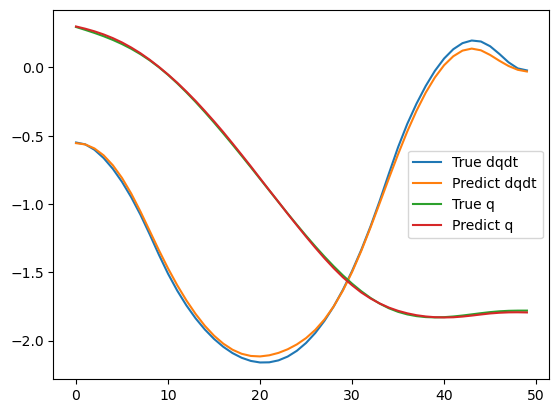

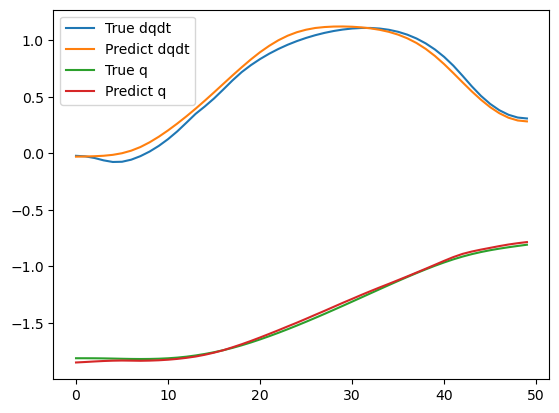

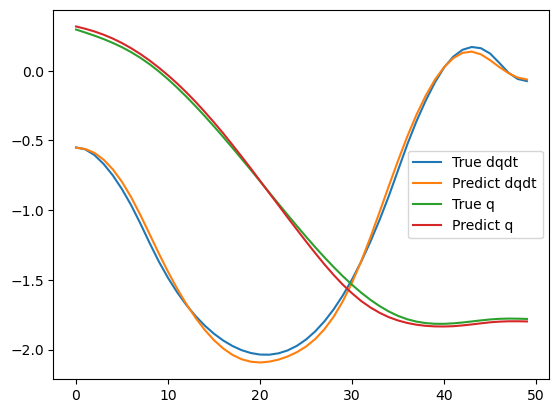

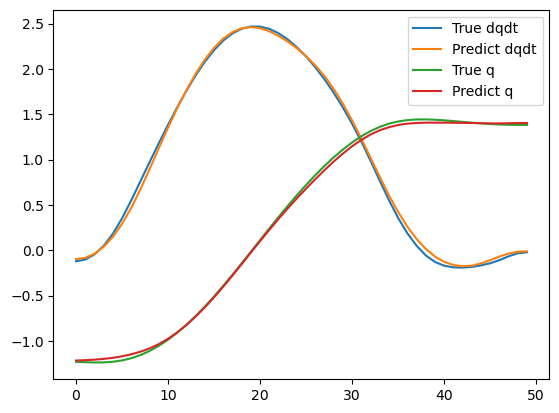

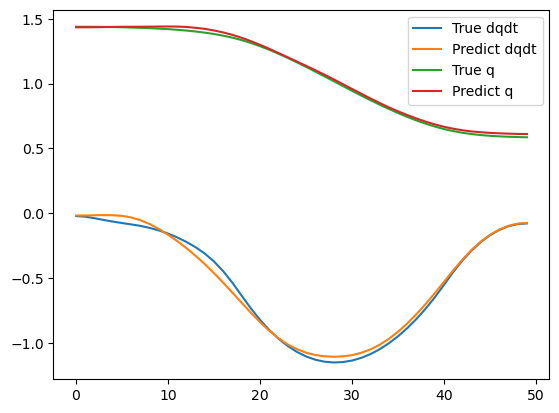

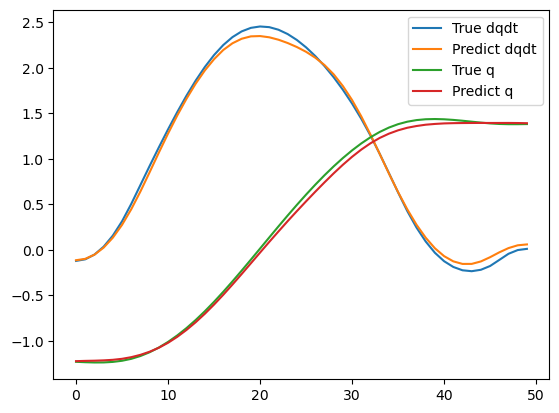

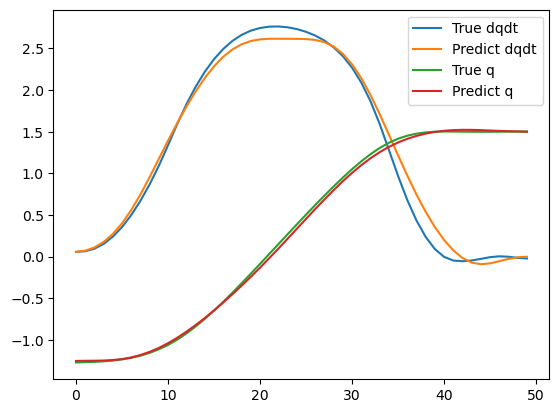

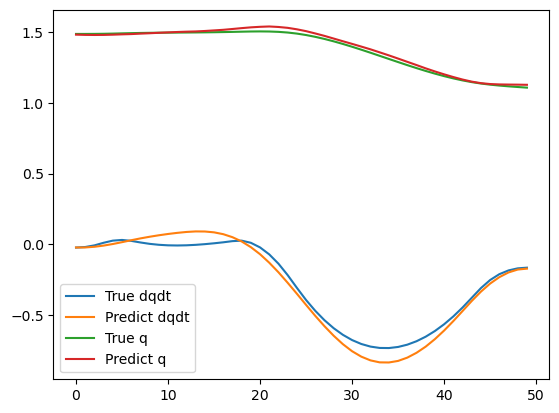

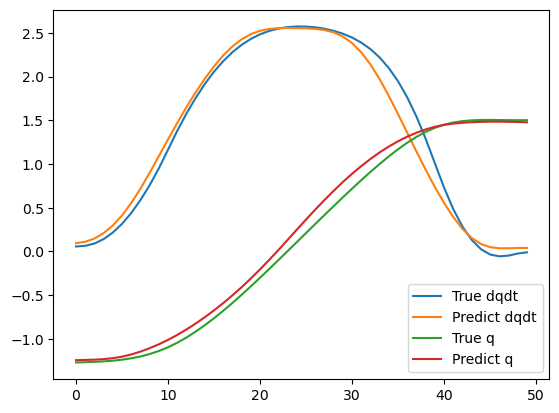

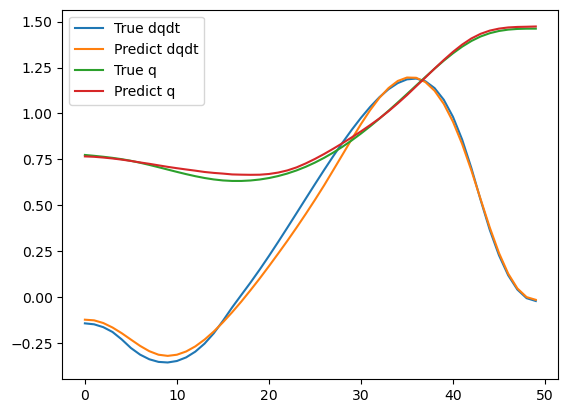

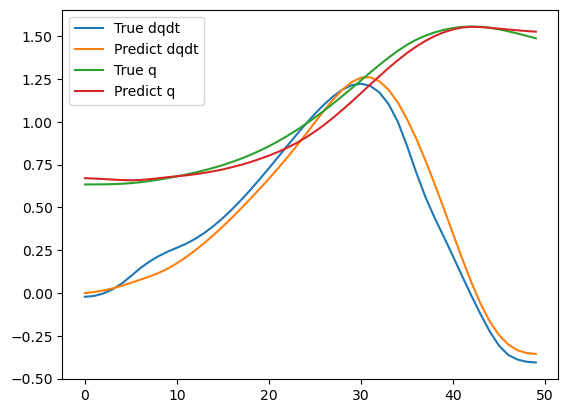

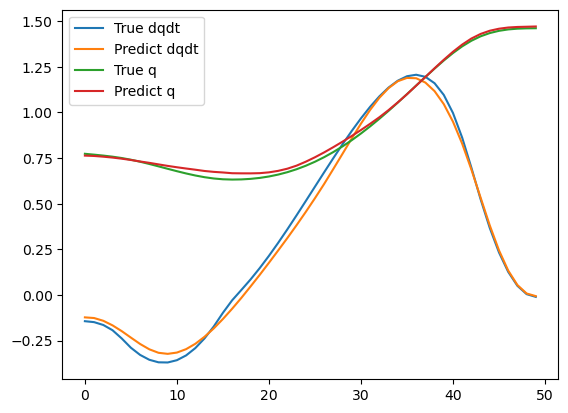

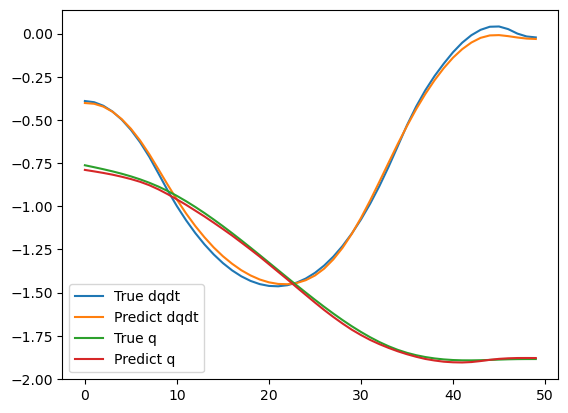

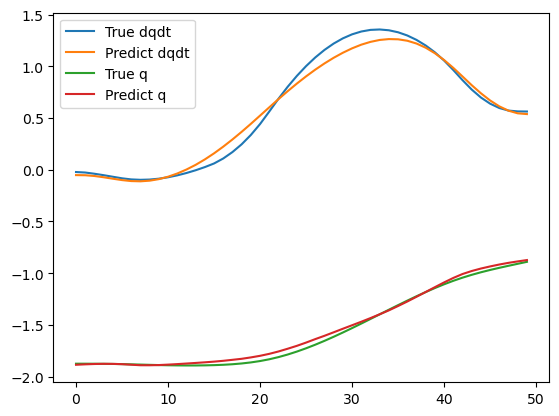

In [20]:
dqdt_out, q_out = net(I_test_sc[:32])

for i in range(32):
    plt.plot(dqdt_sc_test[i].detach().cpu(), label='True dqdt')
    plt.plot(dqdt_out[i].detach().cpu(), label='Predict dqdt')
    plt.plot(q_sc_test[i].detach().cpu(), label='True q')
    plt.plot(q_out[i].detach().cpu(), label='Predict q')
    plt.legend()
    
    plt.show();